# Semi-Supervised Learning Models

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',35)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.svm import SVC
from xgboost import XGBClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

from radar_plotting import plot_radar

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Modeling Prep

## Load Data

In [6]:
# prelabeled set used for initial training
prelabeled_df = pd.read_csv('../data/finalized_data/training_nocorr')

# unlabeled set used for predictions after initial training
unlabeled_df = pd.read_csv('../data/finalized_data/unlabeled_nocorr')

In [7]:
prelabeled_df.head()

Player    GP   MIN   PTS   FG%  3PA    3P%   REB  AST   TO  \
0    Aaron Gordon: 2015  78.0  23.9   9.2  47.3  1.8   29.6   6.5  1.6  0.8   
1      Al Horford: 2015  82.0  32.1  15.2  50.5  3.1   34.4   7.3  3.2  1.3   
2    Al Jefferson: 2015  47.0  23.3  12.0  48.5  0.0    0.0   6.4  1.5  0.7   
3  Andre Drummond: 2015  81.0  32.9  16.2  52.1  0.1   33.3  14.8  0.8  1.9   
4    Andrew Bogut: 2015  70.0  20.7   5.4  62.7  0.0  100.0   7.0  2.3  1.2   

   STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  Height  \
0  0.8  0.7        4.3       60.5      1.3     31.7       0.6     2.2    81.0   
1  0.8  1.5        5.6       64.3      4.1     44.4       3.8     2.1    82.0   
2  0.6  0.9        6.8       51.5      4.0     43.9      11.3     0.0    82.0   
3  1.5  1.4       12.2       54.1      0.8     25.0       6.0     0.9    83.0   
4  0.5  1.6        3.8       65.8      0.1     30.0       2.5     0.1    84.0   

  Pos  Class TEAM  
0  PF    7.0  ORL  
1   C    3.0  ATL  
2   C    2.0  CHA  
3   C    2.0  DET  
4   C    2.0  GSW

To prevent class imbalances, I tried to get at least 30 and less than 40 players of each class.

In [8]:
prelabeled_df['Class'].value_counts()

5.0     36
7.0     34
4.0     33
1.0     33
2.0     33
10.0    32
3.0     31
11.0    30
8.0     30
9.0     30
6.0     30
Name: Class, dtype: int64

In [9]:
unlabeled_df.head()

Player    GP   MIN   PTS   FG%  3PA   3P%  REB  AST   TO  \
0  Al-Farouq Aminu: 2015  82.0  28.5  10.2  41.6  4.3  36.1  6.1  1.7  1.5   
1       Alec Burks: 2015  31.0  25.7  13.3  41.0  2.5  40.5  3.5  2.0  1.6   
2         Alex Len: 2015  78.0  23.3   9.0  42.3  0.1  14.3  7.6  1.2  1.9   
3     Allen Crabbe: 2015  81.0  26.0  10.3  45.9  3.5  39.3  2.7  1.2  0.8   
4       Alonzo Gee: 2015  73.0  22.4   4.5  51.8  0.8  28.3  3.4  1.0  0.8   

   STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  Height  \
0  0.9  0.6        3.4       50.0      1.1     37.6       0.4     3.5    81.0   
1  0.6  0.1        5.1       47.1      3.1     32.3       0.0     8.0    78.0   
2  0.5  0.8        5.4       46.3      2.5     32.6       5.0     0.6    85.0   
3  0.8  0.2        1.7       58.8      3.1     44.8       0.1     1.8    78.0   
4  0.9  0.2        2.3       65.2      0.4     25.0       0.1     1.5    78.0   

  Pos  Class TEAM  
0  SF    NaN  POR  
1  SG    NaN  UTA  
2   C    NaN  PHX  
3  SG    NaN  POR  
4  SF    NaN  NOP

## Model Functions & Metrics

**Build Model Function**

In [10]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True, n_classes=11):
    start = time.time()
    
    # make sure to uncomment the next line for logistic regression
    #clf = OneVsRestClassifier(model)
    
    # comment this next line for logistic regression
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score

**Plot Feature Importances** 

In [11]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase_1_features')

**Plot Confusion Matrix**

In [12]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase2_confusion')

**Plot Metrics**

In [13]:
def print_model_metrics(y_pred,y_score,y_test):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    
    #print('Training Set Metrics:')
    print('Accuracy: {}\n'.format(round(accuracy,4)))
    print('Micro Precision: {}'.format(round(precision,4)))
    print('Micro Recall: {}'.format(round(recall,4)))
    print('Micro F1: {}\n'.format(round(f1,4)))

    print('Macro Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

## Categorical Variables

In [14]:
X = prelabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
y = prelabeled_df['Class']

In [15]:
# get dummy variables for position
X = pd.get_dummies(X)
X.head()

MIN   PTS   FG%  3PA    3P%   REB  AST   TO  STL  BLK  Close FGA  \
0  23.9   9.2  47.3  1.8   29.6   6.5  1.6  0.8  0.8  0.7        4.3   
1  32.1  15.2  50.5  3.1   34.4   7.3  3.2  1.3  0.8  1.5        5.6   
2  23.3  12.0  48.5  0.0    0.0   6.4  1.5  0.7  0.6  0.9        6.8   
3  32.9  16.2  52.1  0.1   33.3  14.8  0.8  1.9  1.5  1.4       12.2   
4  20.7   5.4  62.7  0.0  100.0   7.0  2.3  1.2  0.5  1.6        3.8   

   Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  Height  Pos_C  Pos_PF  \
0       60.5      1.3     31.7       0.6     2.2    81.0      0       1   
1       64.3      4.1     44.4       3.8     2.1    82.0      1       0   
2       51.5      4.0     43.9      11.3     0.0    82.0      1       0   
3       54.1      0.8     25.0       6.0     0.9    83.0      1       0   
4       65.8      0.1     30.0       2.5     0.1    84.0      1       0   

   Pos_PG  Pos_SF  Pos_SG  
0       0       0       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0

## Train Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [17]:
y_train

153    11.0
94      2.0
108     6.0
109    11.0
155     9.0
       ... 
240    11.0
313     6.0
143     3.0
241     2.0
111     1.0
Name: Class, Length: 264, dtype: float64

In [18]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Scale Data
Scaling is done after the train test split in order to ensure that the training set is not influenced at all by the test set.

In [19]:
# scale using MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.fit_transform(X_test)

# convert back into DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [20]:
X_train_scaled.head()

MIN       PTS       FG%       3PA    3P%       REB       AST  \
0  0.522222  0.409639  0.297059  0.272727  0.314  0.616667  0.277228   
1  0.616667  0.237952  0.602941  0.000000  0.000  0.716667  0.089109   
2  0.900000  0.445783  0.188235  0.310606  0.331  0.216667  0.138614   
3  0.905556  0.759036  0.470588  0.166667  0.340  0.775000  0.168317   
4  0.916667  0.572289  0.164706  0.583333  0.401  0.325000  0.267327   

         TO       STL       BLK  Close FGA  Close FG%   Mid FGA   Mid FG%  \
0  0.340426  0.388889  0.379310   0.534884   0.623377  0.366337  0.646177   
1  0.255319  0.111111  0.241379   0.488372   0.716883  0.128713  0.613193   
2  0.297872  0.444444  0.206897   0.503876   0.633766  0.455446  0.476762   
3  0.404255  0.666667  0.896552   0.875969   0.815584  0.534653  0.545727   
4  0.510638  0.944444  0.172414   0.372093   0.529870  0.376238  0.497751   

   Post_Ups    Drives  Height  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
0  0.438849  0.120192  0.8125    1.0     0.0     0.0     0.0     0.0  
1  0.223022  0.004808  0.7500    1.0     0.0     0.0     0.0     0.0  
2  0.179856  0.370192  0.5625    0.0     0.0     0.0     1.0     0.0  
3  0.460432  0.197115  0.6875    0.0     1.0     0.0     0.0     0.0  
4  0.071942  0.427885  0.6250    0.0     0.0     0.0     1.0     0.0

# Stage 1 Modeling

Modeling is done on the prelabeled data for this stage. The model created will be used to make predictions on the non-labeled data. In Stage 2, that newly labeled data will be used to create a new model.

## Random Forest

In [21]:
# tried scaled data as well, but better results achieved with non-scaled data
rf, rf_y_preds, rf_y_score = build_model(RandomForestClassifier(),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 0.22358298301696777 seconds


Accuracy: 0.7045

Micro Precision: 0.7045
Micro Recall: 0.7045
Micro F1: 0.7045

Macro Precision: 0.7203
Macro Recall: 0.7424
Macro F1-score: 0.7196

Weighted Precision: 0.7042
Weighted Recall: 0.7045
Weighted F1-score: 0.6933


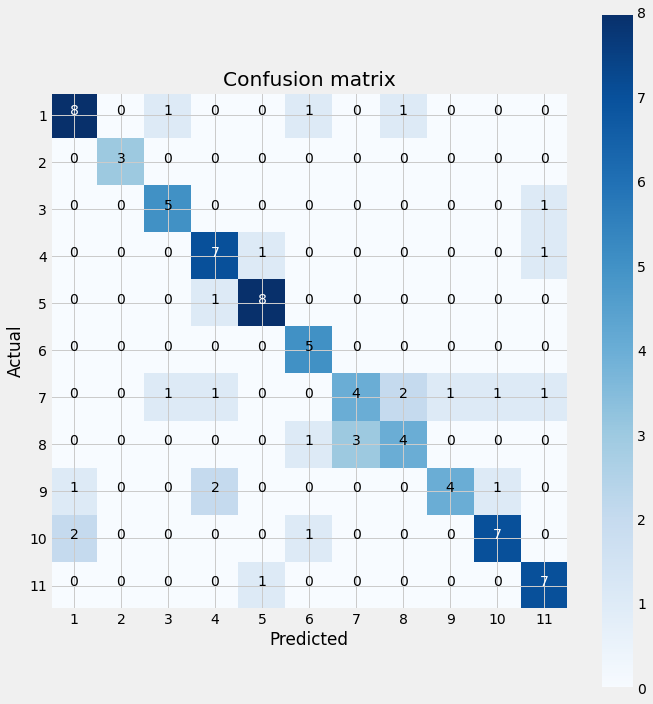

In [22]:
print_model_metrics(rf_y_preds, rf_y_score, y_test)

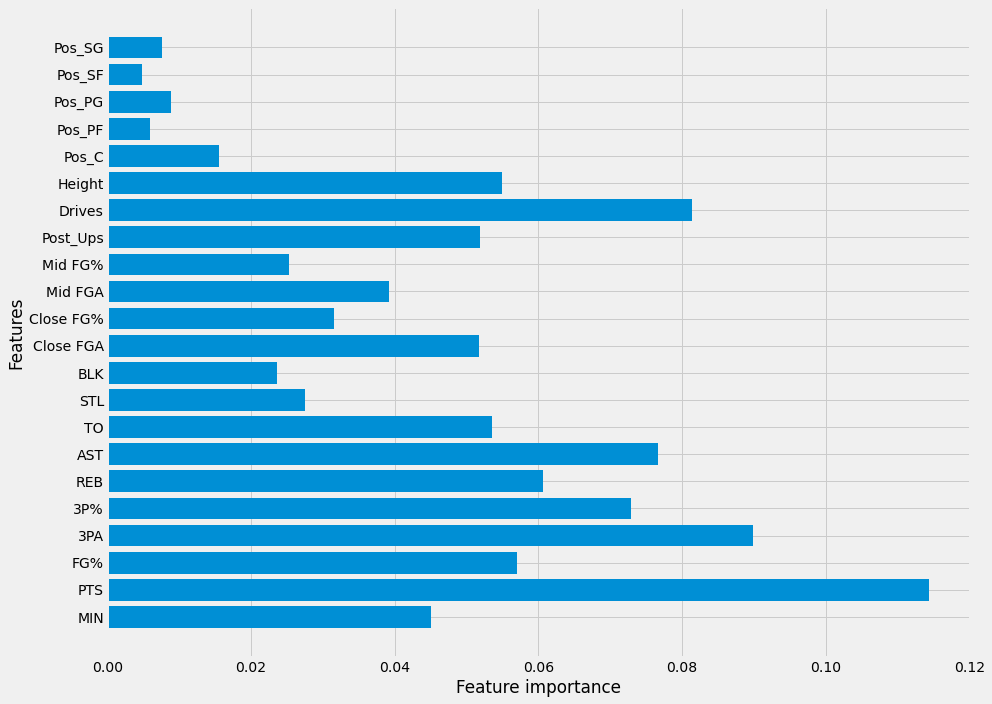

In [23]:
plot_feature_importances(rf)

**Gridsearch**

In [24]:
rf_param_grid = {"n_estimators": [100, 200, 300],
                  "min_samples_leaf": [3, 5],
                  "min_samples_split": [5,10,15],
                  "criterion": ["gini", "entropy"]
                }

In [25]:
rf_gs, rf_gs_y_preds, rf_gs_y_score = build_model(GridSearchCV(rf, param_grid=rf_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 49.40139603614807 seconds


Accuracy: 0.7159

Micro Precision: 0.7159
Micro Recall: 0.7159
Micro F1: 0.7159

Macro Precision: 0.7368
Macro Recall: 0.7432
Macro F1-score: 0.7117

Weighted Precision: 0.7378
Weighted Recall: 0.7159
Weighted F1-score: 0.6993


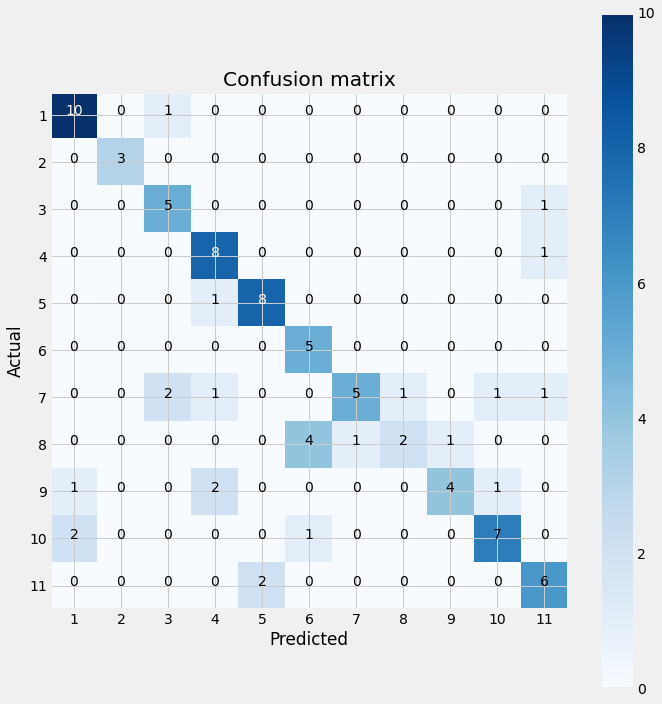

In [26]:
print_model_metrics(rf_gs_y_preds, rf_gs_y_score, y_test)

In [27]:
rf_gs.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [28]:
rf_gs.best_score_

0.7234397677793905

In [29]:
print(f'Training Accuracy: {rf_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {rf_gs.score(X_test, y_test)}')

Training Accuracy: 0.9621212121212122
Test Accuracy: 0.7159090909090909


## Gradient Boost

In [30]:
gb, gb_y_preds, gb_y_score = build_model(GradientBoostingClassifier(),
                                         X_train, X_test, y_train, y_test)

Total Runtime: 1.398892879486084 seconds


Accuracy: 0.6818

Micro Precision: 0.6818
Micro Recall: 0.6818
Micro F1: 0.6818

Macro Precision: 0.7044
Macro Recall: 0.6738
Macro F1-score: 0.6788

Weighted Precision: 0.7063
Weighted Recall: 0.6818
Weighted F1-score: 0.6843


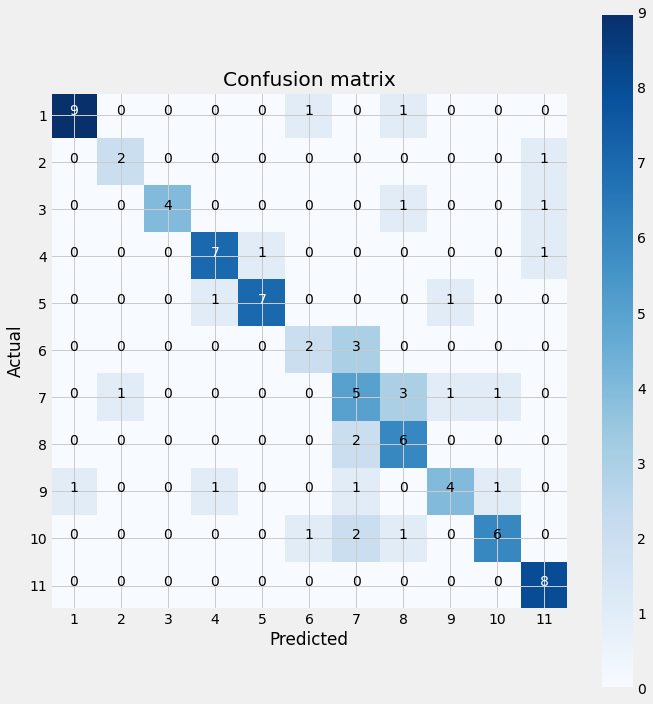

In [31]:
print_model_metrics(gb_y_preds, gb_y_score, y_test)

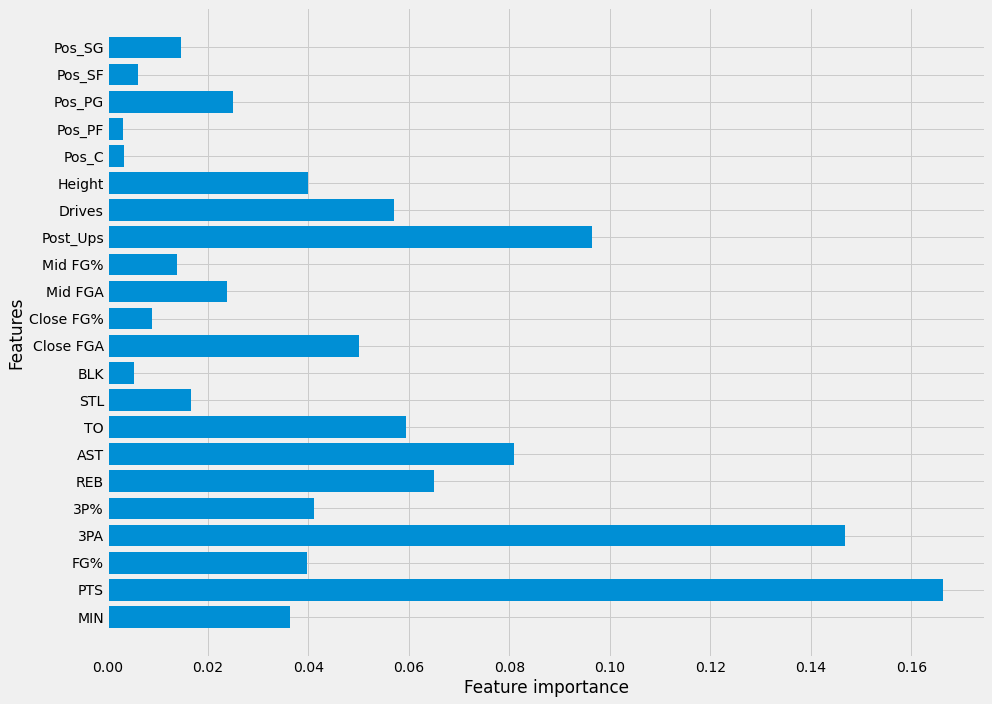

In [32]:
plot_feature_importances(gb)

**Gridsearch**

In [33]:
gb_param_grid = {"n_estimators": [50, 100, 250],
                  "learning_rate": [.005, .01, .1]
                }

gb_gs, gb_gs_y_preds, gb_gs_y_score = build_model(GridSearchCV(gb, param_grid=gb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 72.8404688835144 seconds


Accuracy: 0.6705

Micro Precision: 0.6705
Micro Recall: 0.6705
Micro F1: 0.6705

Macro Precision: 0.6643
Macro Recall: 0.6595
Macro F1-score: 0.6559

Weighted Precision: 0.6771
Weighted Recall: 0.6705
Weighted F1-score: 0.6678


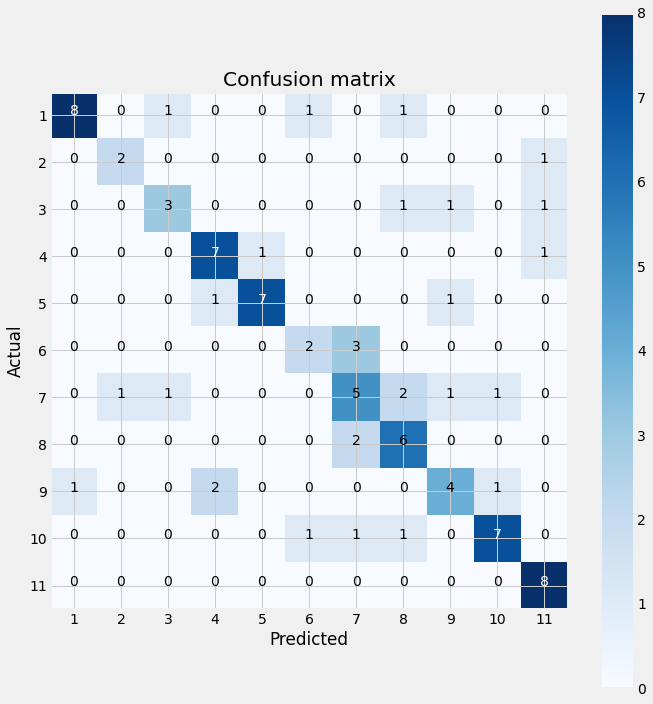

In [34]:
print_model_metrics(gb_gs_y_preds, gb_gs_y_score, y_test)

In [35]:
print(gb_gs.best_params_)

print(f'Training Accuracy: {gb_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {gb_gs.score(X_test, y_test)}')

{'learning_rate': 0.1, 'n_estimators': 100}
Training Accuracy: 1.0
Test Accuracy: 0.6704545454545454


## AdaBoost

In [36]:
ada, ada_y_preds, ada_y_score = build_model(AdaBoostClassifier(algorithm="SAMME",
                                                              learning_rate=.05),
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.11799192428588867 seconds


Accuracy: 0.1818

Micro Precision: 0.1818
Micro Recall: 0.1818
Micro F1: 0.1818

Macro Precision: 0.0844
Macro Recall: 0.2626
Macro F1-score: 0.1107

Weighted Precision: 0.0790
Weighted Recall: 0.1818
Weighted F1-score: 0.0970


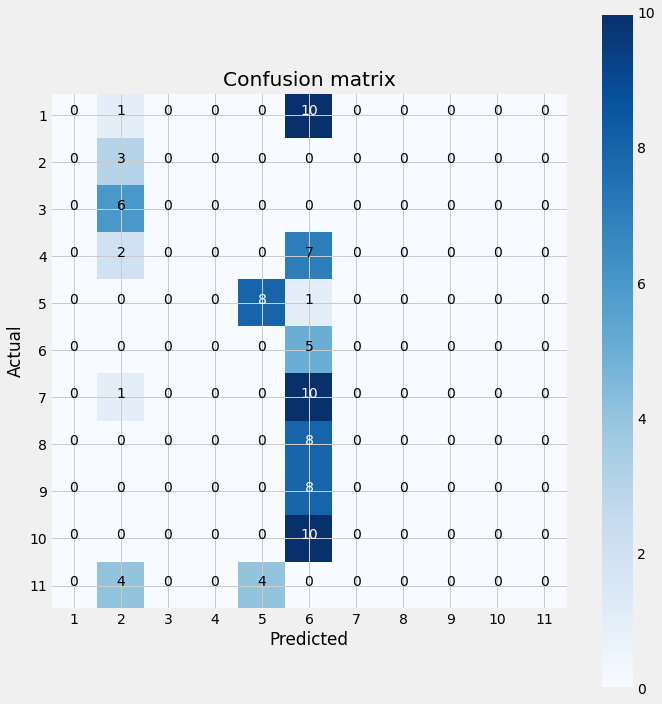

In [37]:
print_model_metrics(ada_y_preds, ada_y_score, y_test)

## XGBoost

In [38]:
xgb, xgb_y_preds, xgb_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 0.32630300521850586 seconds


Accuracy: 0.7273

Micro Precision: 0.7273
Micro Recall: 0.7273
Micro F1: 0.7273

Macro Precision: 0.7264
Macro Recall: 0.7240
Macro F1-score: 0.7161

Weighted Precision: 0.7440
Weighted Recall: 0.7273
Weighted F1-score: 0.7257


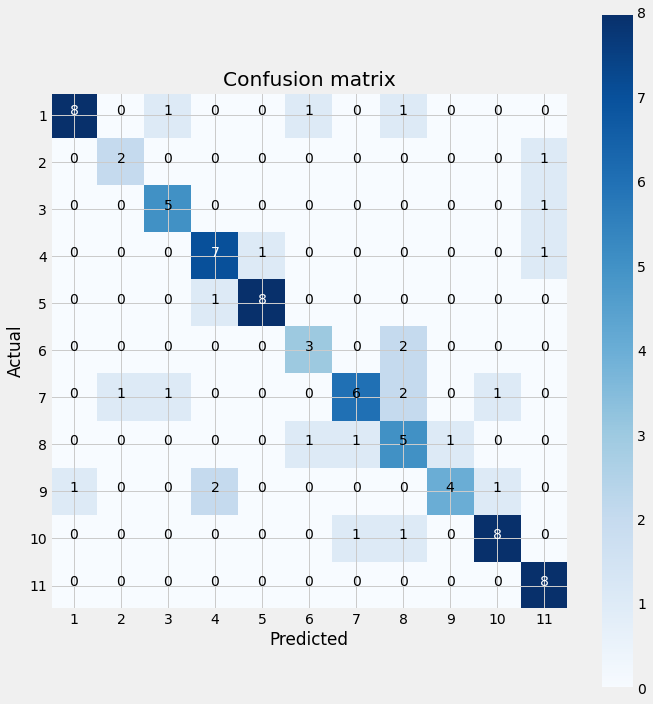

In [39]:
print_model_metrics(xgb_y_preds, xgb_y_score, y_test)

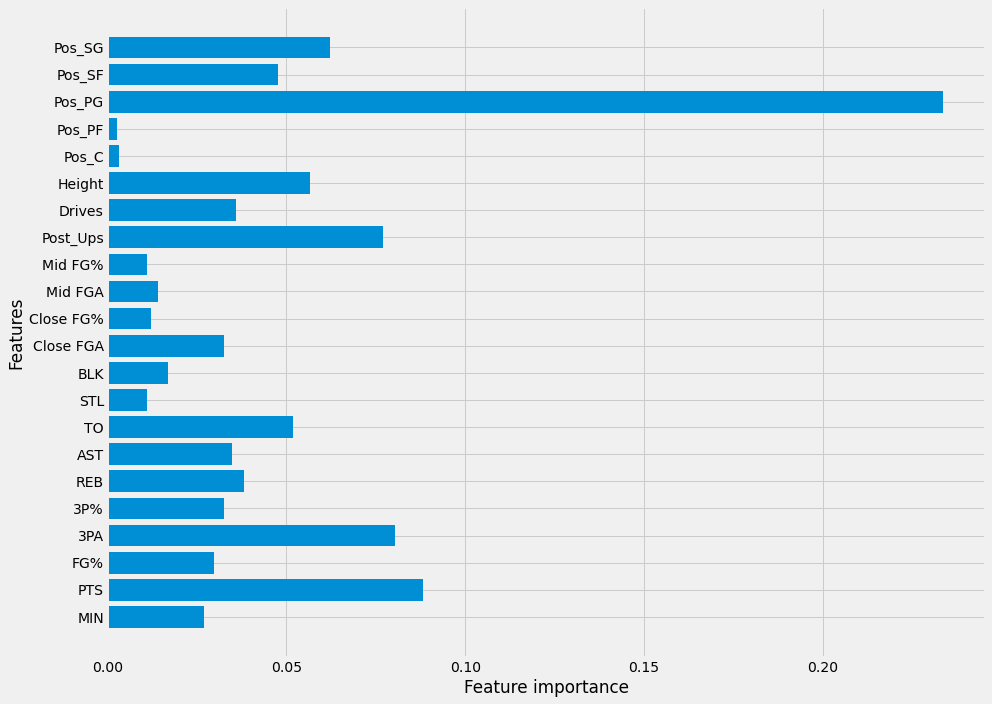

In [40]:
plot_feature_importances(xgb)

In [52]:
%reset_selective -f xgb_gs

In [49]:
xgb_param_grid = {"min_child_weight": [1, 2],
                  "max_depth": [4, 6, 7],
                  "learning_rate": [.001, .01, .1]
                }

xgb_gs, xgb_gs_y_preds, xgb_gs_y_score = build_model(GridSearchCV(xgb, param_grid=xgb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 26.485565900802612 seconds


Accuracy: 0.7273

Micro Precision: 0.7273
Micro Recall: 0.7273
Micro F1: 0.7273

Macro Precision: 0.7412
Macro Recall: 0.7195
Macro F1-score: 0.7140

Weighted Precision: 0.7478
Weighted Recall: 0.7273
Weighted F1-score: 0.7223


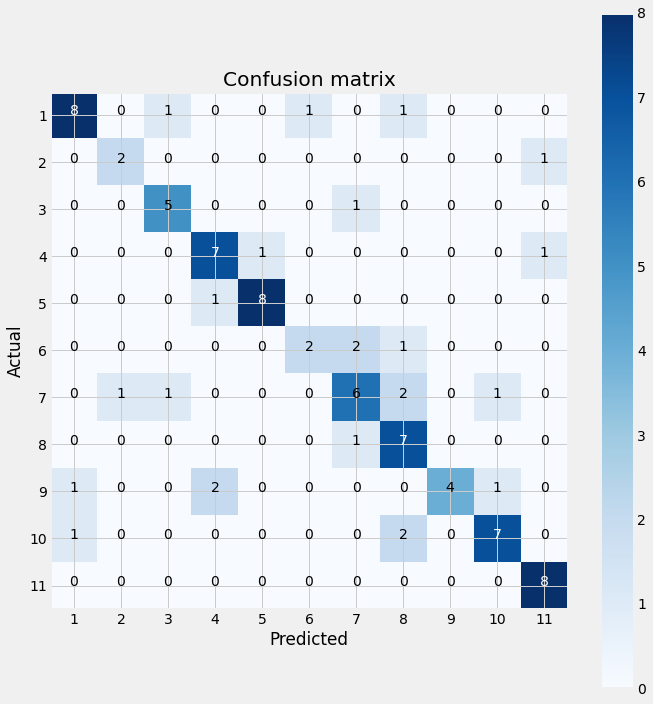

In [50]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [51]:
xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1}

Try manually tuning as well.

In [86]:
%reset_selective -f xgb_man

In [87]:
xgb_man, xgb_man_y_preds, xgb_man_y_score = build_model(XGBClassifier(objective='multi:softmax',
                                                                     learning_rate=.1,
                                                                     n_estimators=1000,
                                                                     max_depth=3,
                                                                     colsample_bytree=.8), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 1.1482069492340088 seconds


Accuracy: 0.7614

Micro Precision: 0.7614
Micro Recall: 0.7614
Micro F1: 0.7614

Macro Precision: 0.7833
Macro Recall: 0.7740
Macro F1-score: 0.7619

Weighted Precision: 0.7845
Weighted Recall: 0.7614
Weighted F1-score: 0.7559


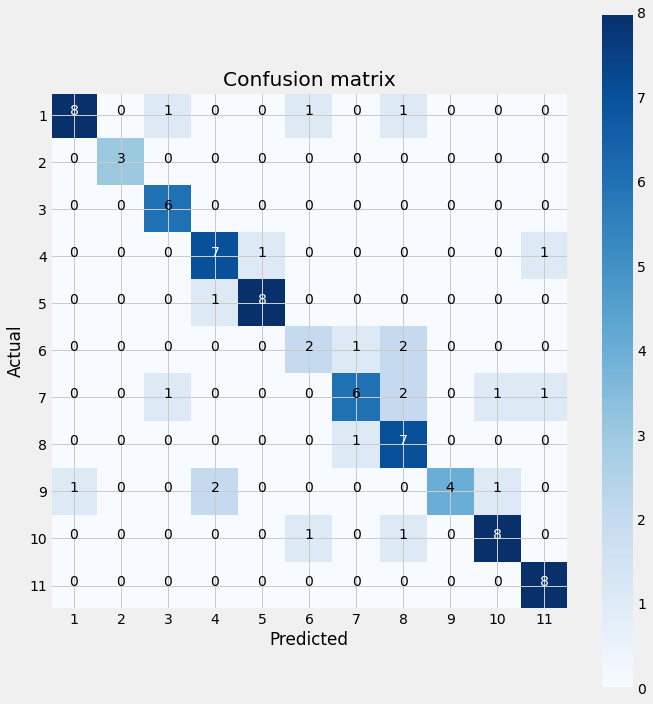

In [88]:
print_model_metrics(xgb_man_y_preds, xgb_man_y_score, y_test)

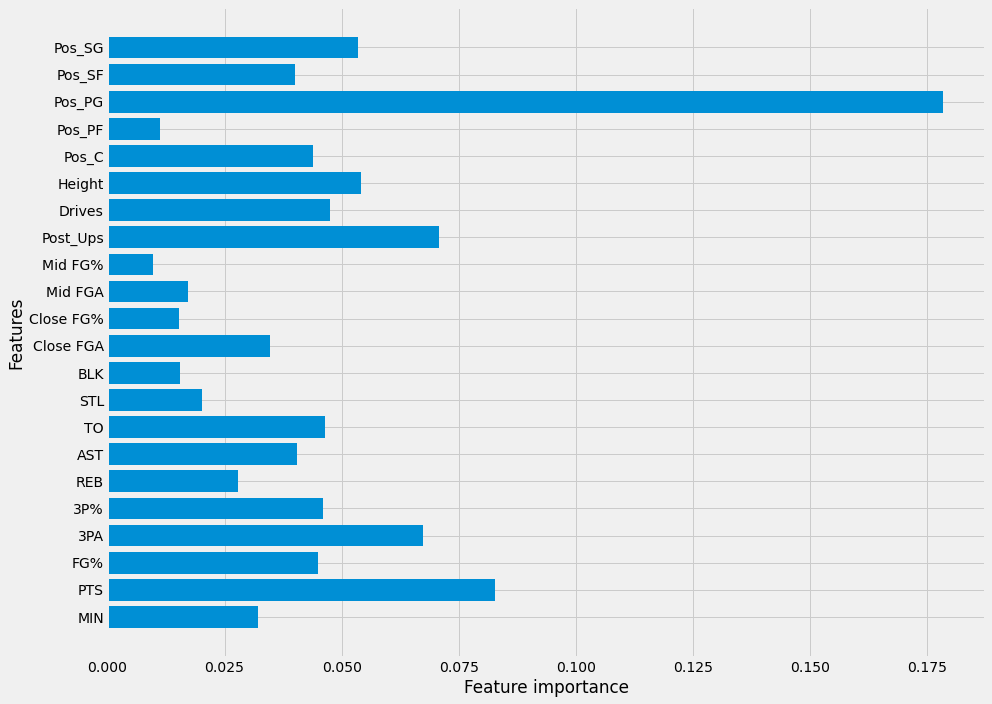

In [61]:
plot_feature_importances(xgb_man)

## SVM: Support Vector Machine

In [89]:
svm, svm_y_preds, svm_y_score = build_model(SVC(decision_function_shape='ovo'), 
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.05181384086608887 seconds


Accuracy: 0.25

Micro Precision: 0.25
Micro Recall: 0.25
Micro F1: 0.25

Macro Precision: 0.2964
Macro Recall: 0.3134
Macro F1-score: 0.1854

Weighted Precision: 0.2463
Weighted Recall: 0.2500
Weighted F1-score: 0.1511


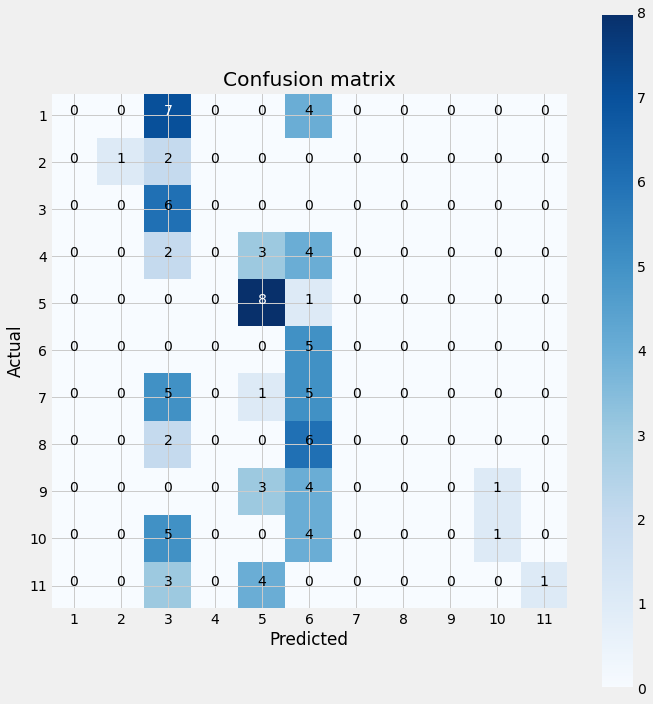

In [90]:
print_model_metrics(svm_y_preds, svm_y_score, y_test)

# Stage 2 Modeling

This stage will create predictions from the previous model on the non-labeled data. Afterwards, the predictions will be used to train a new model.

The best model from the previous stage was the XGBoost.

## Data Preparation

In [18]:
# make predictions

pred_set = unlabeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
pred_set = pd.get_dummies(pred_set)
pred_set.head()

MIN   PTS   FGA   FG%  3PA   3P%  REB  AST   TO  STL  BLK  Close FGA  \
0  28.5  10.2   8.8  41.6  4.3  36.1  6.1  1.7  1.5  0.9  0.6        3.4   
1  25.7  13.3  10.8  41.0  2.5  40.5  3.5  2.0  1.6  0.6  0.1        5.1   
2  23.3   9.0   8.0  42.3  0.1  14.3  7.6  1.2  1.9  0.5  0.8        5.4   
3  26.0  10.3   8.4  45.9  3.5  39.3  2.7  1.2  0.8  0.8  0.2        1.7   
4  22.4   4.5   3.5  51.8  0.8  28.3  3.4  1.0  0.8  0.9  0.2        2.3   

   Close FG%  Mid FGA  Mid FG%  Post_Ups  Drives  CS_3PA  CS_3P%  PP100Pos  \
0       50.0      1.1     37.6       0.4     3.5     4.0    36.3      17.5   
1       47.1      3.1     32.3       0.0     8.0     1.5    40.4      26.1   
2       46.3      2.5     32.6       5.0     0.6     0.1    16.7      18.6   
3       58.8      3.1     44.8       0.1     1.8     3.2    41.1      19.2   
4       65.2      0.4     25.0       0.1     1.5     0.7    30.2       9.7   

   AST %  REB %  USG %  Height  Pos_C  Pos_PF  Pos_PG  Pos_SF  Pos_SG  
0    8.7   10.4   16.6    81.0      0       0       0       1       0  
1   14.0    6.9   24.6    78.0      0       0       0       0       1  
2    8.7   15.6   20.2    85.0      1       0       0       0       0  
3    7.2    4.9   15.9    78.0      0       0       0       0       1  
4    6.3    7.3    9.1    78.0      0       0       0       1       0

In [19]:
unlabeled_df['Class'] = xgb.predict(pred_set)
unlabeled_df

Player    GP   MIN   PTS   FGA   FG%  3PA   3P%  REB  \
0       Al-Farouq Aminu: 2015  82.0  28.5  10.2   8.8  41.6  4.3  36.1  6.1   
1            Alec Burks: 2015  31.0  25.7  13.3  10.8  41.0  2.5  40.5  3.5   
2              Alex Len: 2015  78.0  23.3   9.0   8.0  42.3  0.1  14.3  7.6   
3          Allen Crabbe: 2015  81.0  26.0  10.3   8.4  45.9  3.5  39.3  2.7   
4            Alonzo Gee: 2015  73.0  22.4   4.5   3.5  51.8  0.8  28.3  3.4   
...                       ...   ...   ...   ...   ...   ...  ...   ...  ...   
1026    Wayne Ellington: 2020  31.0  23.2  10.7   8.0  45.8  6.4  43.1  1.8   
1027  Wendell Carter Jr: 2020  32.0  24.7  10.9   7.9  51.2  0.7  36.4  7.8   
1028    Wesley Matthews: 2020  37.0  20.1   4.5   4.1  35.9  3.3  34.7  1.4   
1029        Will Barton: 2020  41.0  30.7  12.7  11.0  43.5  4.7  37.7  4.1   
1030        Zach LaVine: 2020  43.0  35.3  28.1  19.3  52.0  8.1  43.7  5.0   

      AST   TO  STL  BLK  Close FGA  Close FG%  Mid FGA  Mid FG%  Post_Ups  \
0     1.7  1.5  0.9  0.6        3.4       50.0      1.1     37.6       0.4   
1     2.0  1.6  0.6  0.1        5.1       47.1      3.1     32.3       0.0   
2     1.2  1.9  0.5  0.8        5.4       46.3      2.5     32.6       5.0   
3     1.2  0.8  0.8  0.2        1.7       58.8      3.1     44.8       0.1   
4     1.0  0.8  0.9  0.2        2.3       65.2      0.4     25.0       0.1   
...   ...  ...  ...  ...        ...        ...      ...      ...       ...   
1026  1.5  0.7  0.4  0.2        1.1       63.6      0.7     40.0       0.0   
1027  2.2  1.5  0.6  0.8        5.9       55.9      1.2     38.5       2.5   
1028  1.0  0.5  0.5  0.4        0.6       50.0      0.3     20.0       0.3   
1029  3.1  1.7  0.9  0.4        5.2       50.0      1.2     41.7       0.0   
1030  4.9  3.8  0.9  0.5        8.4       63.1      2.8     44.6       0.4   

      Drives  CS_3PA  CS_3P%  PP100Pos  AST %  REB %  USG %  Height Pos  \
0        3.5     4.0    36.3      17.5    8.7   10.4   16.6    81.0  SF   
1        8.0     1.5    40.4      26.1   14.0    6.9   24.6    78.0  SG   
2        0.6     0.1    16.7      18.6    8.7   15.6   20.2    85.0   C   
3        1.8     3.2    41.1      19.2    7.2    4.9   15.9    78.0  SG   
4        1.5     0.7    30.2       9.7    6.3    7.3    9.1    78.0  SF   
...      ...     ...     ...       ...    ...    ...    ...     ...  ..   
1026     1.9     4.0    41.6      22.4    9.4    3.9   16.8    76.0  SG   
1027     1.0     0.7    36.4      20.6   12.6   15.4   18.5    82.0   C   
1028     1.2     2.8    34.3      10.7    6.5    3.5   10.1    76.0  SG   
1029     6.1     2.9    39.2      20.1   13.2    6.8   19.0    78.0  SF   
1030    12.8     2.7    49.1      37.4   22.5    7.2   30.1    77.0  SG   

      Class TEAM  
0        10  POR  
1         6  UTA  
2         2  PHX  
3         1  POR  
4        10  NOP  
...     ...  ...  
1026      1  DET  
1027      2  ORL  
1028     10  LAL  
1029      8  DEN  
1030      5  CHI  

[1031 rows x 29 columns]

In [20]:
# combine prelabeled data and predictions into one dataset
new_labeled_df = pd.concat([prelabeled_df, unlabeled_df])

Now we need to make our X and y sets, along with a scaled version of X. Then, we split the data using train_test_split to get our training and testing sets.

In [21]:
X2 = new_labeled_df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
X2 = pd.get_dummies(X2)
y2 = new_labeled_df['Class']

In [22]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=17)

Create a scaled set as well to use.

In [23]:
y2_train = y2_train.astype(int)
y2_test = y2_test.astype(int)

# scale using MinMaxScaler
mm = MinMaxScaler()
X2_train_scaled = mm.fit_transform(X2_train)
X2_test_scaled = mm.fit_transform(X2_test)

# convert back into DataFrame to preserve column names
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=X2.columns)
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=X2.columns)

## Modeling

### Random Forest

In [57]:
# tried scaled data as well, but better results achieved with non-scaled data
rf2, rf2_y_preds, rf2_y_score = build_model(RandomForestClassifier(),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 0.4183330535888672 seconds


Accuracy: 0.7746

Micro Precision: 0.7746
Micro Recall: 0.7746
Micro F1: 0.7746

Macro Precision: 0.7547
Macro Recall: 0.7585
Macro F1-score: 0.7457

Weighted Precision: 0.7747
Weighted Recall: 0.7746
Weighted F1-score: 0.7670


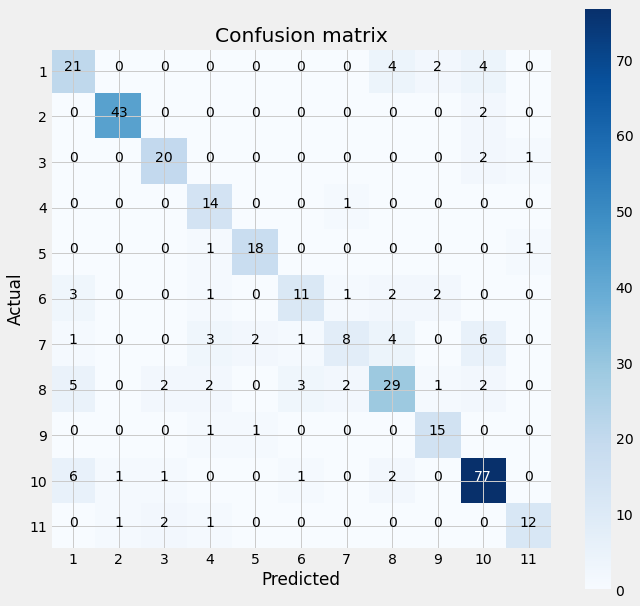

In [58]:
print_model_metrics(rf2_y_preds, rf2_y_score, y2_test)

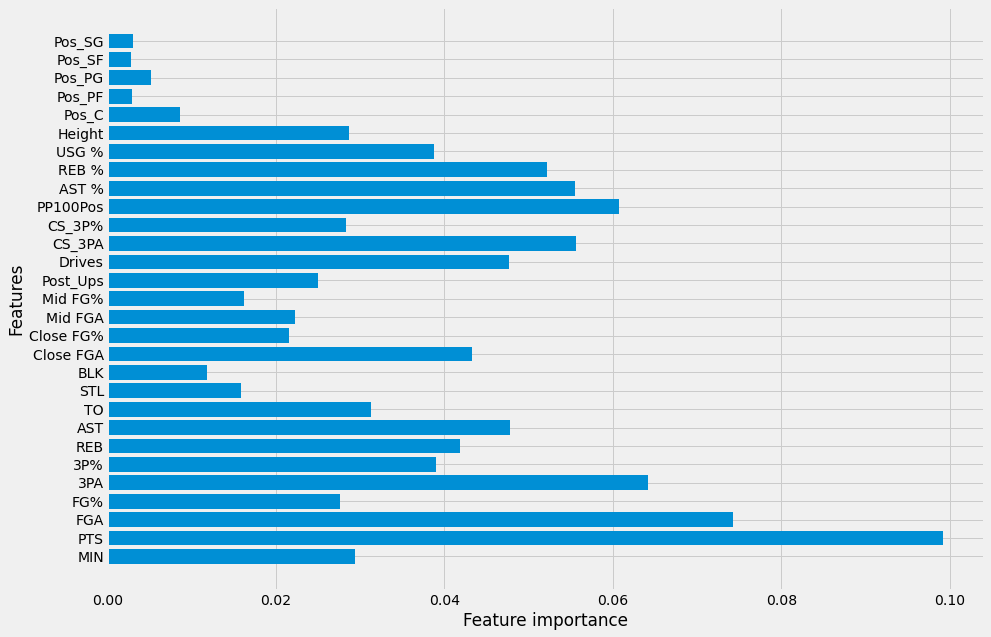

In [59]:
plot_feature_importances(rf2)

In [61]:
print(f'Training Accuracy: {rf2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {rf2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.7745664739884393


**Gridsearch**

In [69]:
rf2_param_grid = {"min_samples_leaf": [1, 3, 5],
                  "min_samples_split": [2, 4, 6],
                  "criterion": ["gini", "entropy"],
                  "n_estimators": [100, 200, 300]
                }

In [70]:
rf2_gs, rf2_gs_y_preds, rf2_gs_y_score = build_model(GridSearchCV(rf2, param_grid=rf2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 128.14771699905396 seconds


Accuracy: 0.7977

Micro Precision: 0.7977
Micro Recall: 0.7977
Micro F1: 0.7977

Macro Precision: 0.7848
Macro Recall: 0.7778
Macro F1-score: 0.7633

Weighted Precision: 0.8057
Weighted Recall: 0.7977
Weighted F1-score: 0.7893


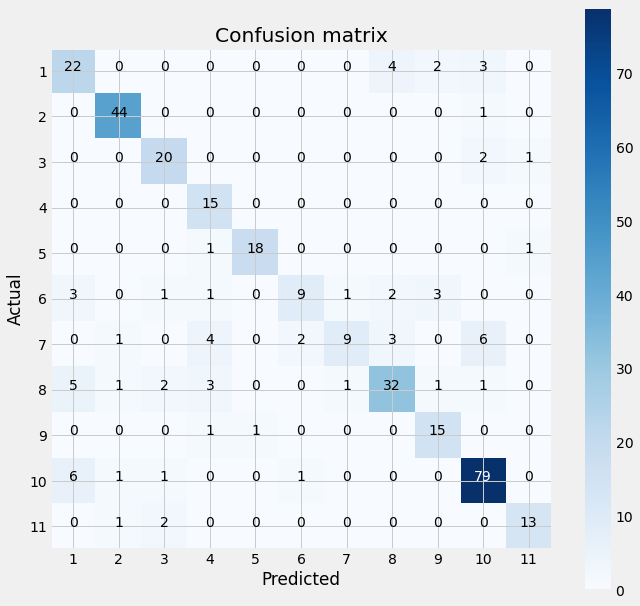

In [71]:
print_model_metrics(rf2_gs_y_preds, rf2_gs_y_score, y2_test)

In [72]:
print(rf2_gs.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Gradient Boost

In [54]:
gb2, gb2_y_preds, gb2_y_score = build_model(GradientBoostingClassifier(),
                                         X2_train, X2_test, y2_train, y2_test)

Total Runtime: 4.575927257537842 seconds


Accuracy: 0.8035

Micro Precision: 0.8035
Micro Recall: 0.8035
Micro F1: 0.8035

Macro Precision: 0.7832
Macro Recall: 0.7810
Macro F1-score: 0.7714

Weighted Precision: 0.8055
Weighted Recall: 0.8035
Weighted F1-score: 0.7969


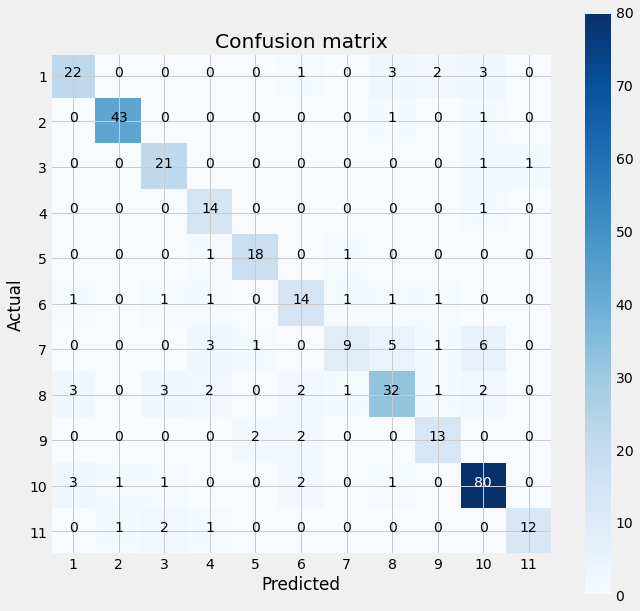

In [60]:
print_model_metrics(gb2_y_preds, gb2_y_score, y2_test)

### XGBoost

In [35]:
xgb2, xgb2_y_preds, xgb2_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X2_train, X2_test, y2_train, y2_test, decision_function=False)

Total Runtime: 0.6532759666442871 seconds


Accuracy: 0.8208

Micro Precision: 0.8208
Micro Recall: 0.8208
Micro F1: 0.8208

Macro Precision: 0.8165
Macro Recall: 0.8123
Macro F1-score: 0.8060

Weighted Precision: 0.8244
Weighted Recall: 0.8208
Weighted F1-score: 0.8170


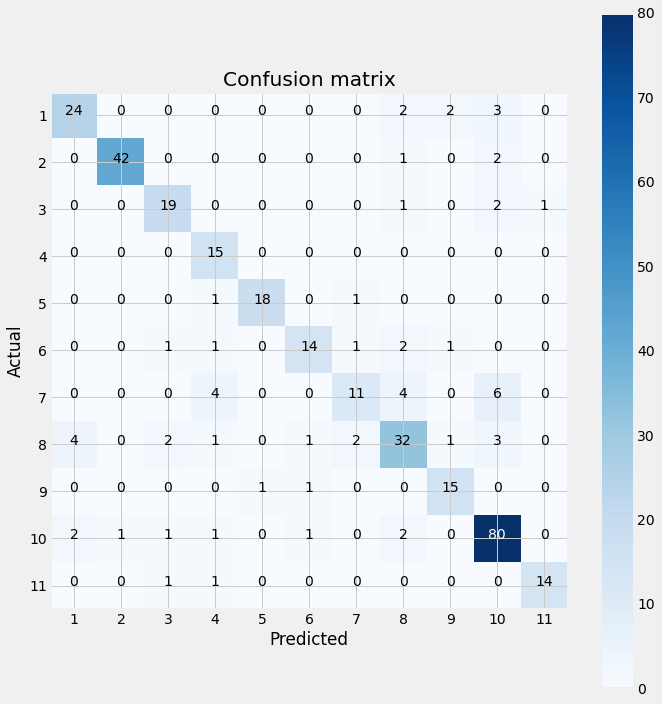

In [40]:
print_model_metrics(xgb2_y_preds, xgb2_y_score, y2_test)

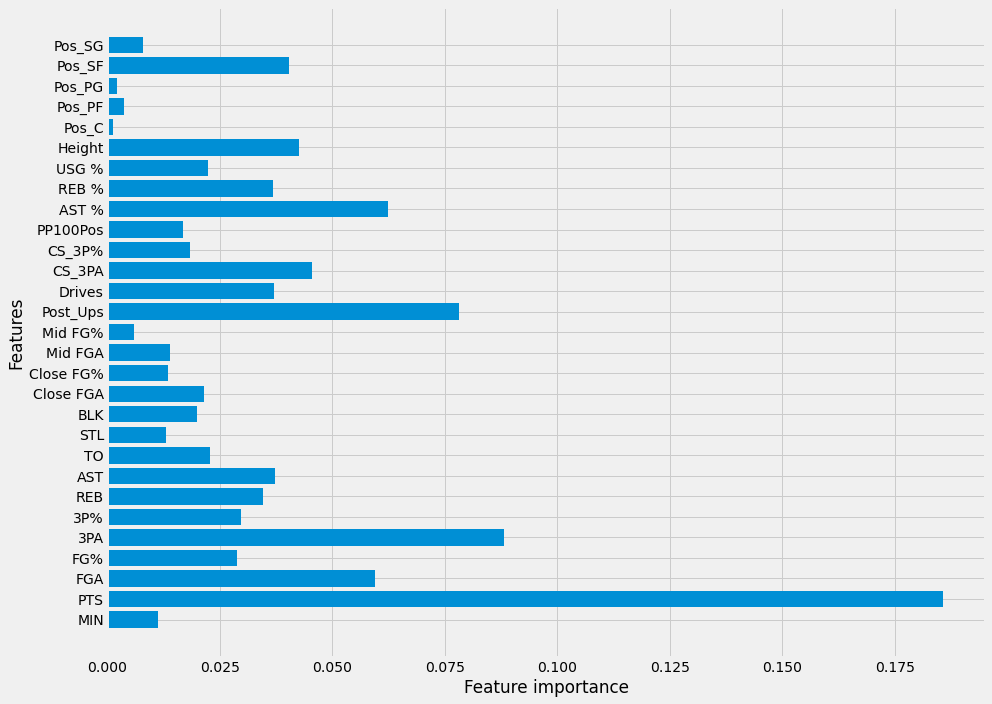

In [37]:
plot_feature_importances(xgb2)

In [134]:
print(f'Training Accuracy: {xgb2.score(X2_train, y2_train)}')
print(f'Test Accuracy: {xgb2.score(X2_test, y2_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.8208092485549133


In [135]:
xgb2.save_model('final_model.model')

**Gridsearch**

In [90]:
xgb2_param_grid = {"min_child_weight": [2, 3, 4],
                  "max_depth": [6, 9, 12],
                  "eta": [.001, .005, .01]
                }

xgb2_gs, xgb2_gs_y_preds, xgb2_gs_y_score = build_model(GridSearchCV(xgb2, param_grid=xgb2_param_grid),
                                                         X2_train, X2_test,
                                                         y2_train, y2_test,
                                                        decision_function=False)

Total Runtime: 88.47410583496094 seconds


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1: 0.75

Macro Precision: 0.7654
Macro Recall: 0.7595
Macro F1-score: 0.7489

Weighted Precision: 0.7851
Weighted Recall: 0.7500
Weighted F1-score: 0.7548


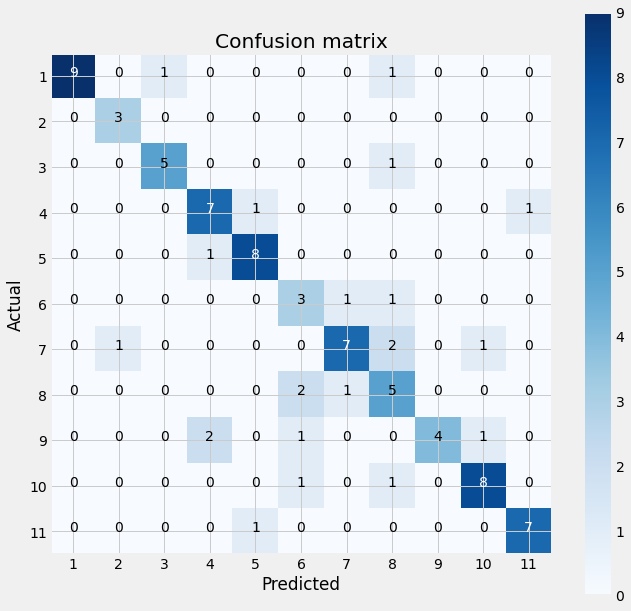

In [91]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [92]:
xgb2_gs.best_params_

{'eta': 0.001, 'max_depth': 9, 'min_child_weight': 3}

### Neural Network

In [27]:
# binarize target column

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y2_train)

In [28]:
labels.shape

(1037, 11)

In [114]:
%reset_selective -f model_1

In [25]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(1037,29)))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dense(11, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [26]:
model_1_results = model_1.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 8ms/step - loss: 2.2976 - acc: 0.2135 - val_loss: 2.0906 - val_acc: 0.3510
Epoch 2/150
26/26 [==============================] - 0s 1ms/step - loss: 2.0240 - acc: 0.3498 - val_loss: 1.8474 - val_acc: 0.4423
Epoch 3/150
26/26 [==============================] - 0s 2ms/step - loss: 1.7958 - acc: 0.4318 - val_loss: 1.6168 - val_acc: 0.5192
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.5938 - acc: 0.4910 - val_loss: 1.4275 - val_acc: 0.5337
Epoch 5/150
26/26 [==============================] - 0s 1ms/step - loss: 1.4276 - acc: 0.5187 - val_loss: 1.2776 - val_acc: 0.5721
Epoch 6/150
26/26 [==============================] - 0s 1ms/step - loss: 1.3058 - acc: 0.5561 - val_loss: 1.1822 - val_acc: 0.5865
Epoch 7/150
26/26 [==============================] - 0s 1ms/step - loss: 1.2099 - acc: 0.5995 - val_loss: 1.1111 - val_acc: 0.5962
Epoch 8/150
26/26 [==============================] - 0s 1ms/step - loss: 1.1363 - a

Epoch 58/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5816 - acc: 0.7805 - val_loss: 0.6453 - val_acc: 0.7308
Epoch 59/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5782 - acc: 0.7877 - val_loss: 0.6385 - val_acc: 0.7260
Epoch 60/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5702 - acc: 0.7841 - val_loss: 0.6210 - val_acc: 0.7500
Epoch 61/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5640 - acc: 0.7889 - val_loss: 0.6354 - val_acc: 0.7163
Epoch 62/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5614 - acc: 0.7841 - val_loss: 0.6175 - val_acc: 0.7404
Epoch 63/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5556 - acc: 0.7913 - val_loss: 0.6278 - val_acc: 0.7356
Epoch 64/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5546 - acc: 0.7925 - val_loss: 0.6182 - val_acc: 0.7452
Epoch 65/150
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 120/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4101 - acc: 0.8492 - val_loss: 0.5663 - val_acc: 0.7596
Epoch 121/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4079 - acc: 0.8444 - val_loss: 0.5630 - val_acc: 0.7837
Epoch 122/150
26/26 [==============================] - 0s 3ms/step - loss: 0.4125 - acc: 0.8516 - val_loss: 0.5795 - val_acc: 0.7644
Epoch 123/150
26/26 [==============================] - 0s 3ms/step - loss: 0.4161 - acc: 0.8335 - val_loss: 0.5632 - val_acc: 0.7740
Epoch 124/150
26/26 [==============================] - 0s 3ms/step - loss: 0.4079 - acc: 0.8432 - val_loss: 0.5634 - val_acc: 0.7740
Epoch 125/150
26/26 [==============================] - 0s 2ms/step - loss: 0.3981 - acc: 0.8492 - val_loss: 0.5840 - val_acc: 0.7356
Epoch 126/150
26/26 [==============================] - 0s 3ms/step - loss: 0.4036 - acc: 0.8420 - val_loss: 0.5982 - val_acc: 0.7308
Epoch 127/150
26/26 [==============================] - 0s 2ms/step - 

Model looks a little overfit. The goal further is to address the overfit model and to minimize loss.

In [60]:
%reset_selective -f model_2

In [61]:
model_2 = Sequential()
#model_2.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_2.add(Dense(128, activation='tanh', input_shape=(29,)))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dropout(.2))
model_2.add(Dense(11, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [62]:
model_2_results = model_2.fit(X2_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 5ms/step - loss: 2.2046 - acc: 0.2738 - val_loss: 1.9084 - val_acc: 0.4471
Epoch 2/150
26/26 [==============================] - 0s 1ms/step - loss: 1.8379 - acc: 0.4041 - val_loss: 1.6113 - val_acc: 0.4808
Epoch 3/150
26/26 [==============================] - 0s 1ms/step - loss: 1.6051 - acc: 0.4572 - val_loss: 1.4010 - val_acc: 0.5529
Epoch 4/150
26/26 [==============================] - 0s 2ms/step - loss: 1.4386 - acc: 0.5139 - val_loss: 1.2478 - val_acc: 0.6010
Epoch 5/150
26/26 [==============================] - 0s 2ms/step - loss: 1.3186 - acc: 0.5585 - val_loss: 1.1563 - val_acc: 0.6298
Epoch 6/150
26/26 [==============================] - 0s 2ms/step - loss: 1.2356 - acc: 0.5887 - val_loss: 1.0830 - val_acc: 0.6250
Epoch 7/150
26/26 [==============================] - 0s 1ms/step - loss: 1.1600 - acc: 0.6236 - val_loss: 1.0247 - val_acc: 0.6538
Epoch 8/150
26/26 [==============================] - 0s 2ms/step - loss: 1.1031 - a

Epoch 125/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5000 - acc: 0.8058 - val_loss: 0.6128 - val_acc: 0.7644
Epoch 126/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4988 - acc: 0.8203 - val_loss: 0.5759 - val_acc: 0.8077
Epoch 127/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4803 - acc: 0.8166 - val_loss: 0.5652 - val_acc: 0.7981
Epoch 128/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4815 - acc: 0.8239 - val_loss: 0.5824 - val_acc: 0.7740
Epoch 129/150
26/26 [==============================] - 0s 2ms/step - loss: 0.4933 - acc: 0.8215 - val_loss: 0.5775 - val_acc: 0.7885
Epoch 130/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4861 - acc: 0.8203 - val_loss: 0.5901 - val_acc: 0.7692
Epoch 131/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4883 - acc: 0.8130 - val_loss: 0.5787 - val_acc: 0.8029
Epoch 132/150
26/26 [==============================] - 0s 1ms/step - 

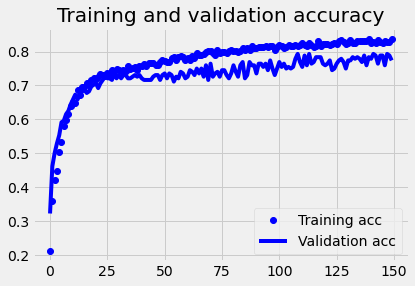

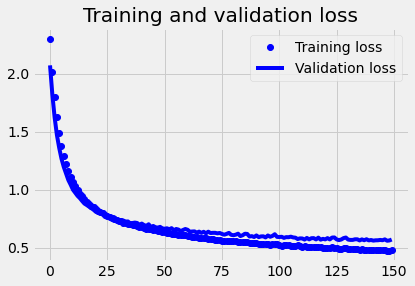

In [133]:
acc = model_2_results.history['acc']
val_acc = model_2_results.history['val_acc']
loss = model_2_results.history['loss']
val_loss = model_2_results.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
%reset_selective -f model_3

In [63]:
model_3 = Sequential()
#model_3.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_3.add(Dense(64, activation='tanh', input_shape=(29,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dropout(.2))
model_3.add(Dense(11, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [65]:
model_3_results = model_3.fit(X2_train_scaled, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 0s 4ms/step - loss: 0.5087 - acc: 0.8179 - val_loss: 0.5631 - val_acc: 0.8029
Epoch 2/100
26/26 [==============================] - 0s 2ms/step - loss: 0.5209 - acc: 0.8166 - val_loss: 0.5442 - val_acc: 0.7885
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4663 - acc: 0.8396 - val_loss: 0.5439 - val_acc: 0.7933
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 0.5044 - acc: 0.8142 - val_loss: 0.5413 - val_acc: 0.8029
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4916 - acc: 0.8154 - val_loss: 0.5428 - val_acc: 0.7933
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4842 - acc: 0.8299 - val_loss: 0.5585 - val_acc: 0.7837
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4887 - acc: 0.8142 - val_loss: 0.5422 - val_acc: 0.7981
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.4682 - a

Epoch 63/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4682 - acc: 0.8166 - val_loss: 0.5647 - val_acc: 0.7788
Epoch 64/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4544 - acc: 0.8191 - val_loss: 0.5685 - val_acc: 0.8125
Epoch 65/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4358 - acc: 0.8347 - val_loss: 0.5649 - val_acc: 0.8029
Epoch 66/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4485 - acc: 0.8347 - val_loss: 0.5529 - val_acc: 0.8029
Epoch 67/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4456 - acc: 0.8372 - val_loss: 0.5569 - val_acc: 0.8077
Epoch 68/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4505 - acc: 0.8408 - val_loss: 0.5545 - val_acc: 0.8125
Epoch 69/100
26/26 [==============================] - 0s 1ms/step - loss: 0.4289 - acc: 0.8504 - val_loss: 0.5561 - val_acc: 0.8125
Epoch 70/100
26/26 [==============================] - 0s 1ms/step - loss: 0.

## Multi-Class Neural Network with Cross Validation

In [33]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_shape=(29,)))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(.2))
    model.add(Dense(11, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [36]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=32, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X2_train, labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/150
26/26 [==============================] - 0s 881us/step - loss: 2.4210 - acc: 0.2111
Epoch 2/150
26/26 [==============================] - 0s 662us/step - loss: 2.0529 - acc: 0.3317
Epoch 3/150
26/26 [==============================] - 0s 934us/step - loss: 1.9154 - acc: 0.3752
Epoch 4/150
26/26 [==============================] - 0s 861us/step - loss: 1.8142 - acc: 0.3969
Epoch 5/150
26/26 [==============================] - 0s 751us/step - loss: 1.7242 - acc: 0.4282
Epoch 6/150
26/26 [==============================] - 0s 697us/step - loss: 1.6355 - acc: 0.4463
Epoch 7/150
26/26 [==============================] - 0s 998us/step - loss: 1.5580 - acc: 0.4729
Epoch 8/150
26/26 [==============================] - 0s 845us/step - loss: 1.5164 - acc: 0.4873
Epoch 9/150
26/26 [==============================] - 0s 982us/step - loss: 1.4605 - acc: 0.4970
Epoch 10/150
26/26 [==============================] - 0s 883us/step - loss: 1.3910 - acc: 0.5320
Epoch 11/150
26/26 [===================

26/26 [==============================] - 0s 804us/step - loss: 0.9558 - acc: 0.6490
Epoch 19/150
26/26 [==============================] - 0s 850us/step - loss: 0.9365 - acc: 0.6659
Epoch 20/150
26/26 [==============================] - 0s 865us/step - loss: 0.9149 - acc: 0.6683
Epoch 21/150
26/26 [==============================] - 0s 731us/step - loss: 0.8938 - acc: 0.6876
Epoch 22/150
26/26 [==============================] - 0s 782us/step - loss: 0.8907 - acc: 0.6960
Epoch 23/150
26/26 [==============================] - 0s 734us/step - loss: 0.8470 - acc: 0.6900
Epoch 24/150
26/26 [==============================] - 0s 783us/step - loss: 0.8319 - acc: 0.6996
Epoch 25/150
26/26 [==============================] - 0s 788us/step - loss: 0.8524 - acc: 0.7045
Epoch 26/150
26/26 [==============================] - 0s 767us/step - loss: 0.8191 - acc: 0.7069
Epoch 27/150
26/26 [==============================] - 0s 835us/step - loss: 0.7843 - acc: 0.7153
Epoch 28/150
26/26 [=======================

26/26 [==============================] - 0s 877us/step - loss: 0.7483 - acc: 0.7289
Epoch 36/150
26/26 [==============================] - 0s 820us/step - loss: 0.7167 - acc: 0.7458
Epoch 37/150
26/26 [==============================] - 0s 824us/step - loss: 0.7605 - acc: 0.7157
Epoch 38/150
26/26 [==============================] - 0s 800us/step - loss: 0.6999 - acc: 0.7434
Epoch 39/150
26/26 [==============================] - 0s 849us/step - loss: 0.7344 - acc: 0.7289
Epoch 40/150
26/26 [==============================] - 0s 752us/step - loss: 0.7013 - acc: 0.7542
Epoch 41/150
26/26 [==============================] - 0s 998us/step - loss: 0.6718 - acc: 0.7506
Epoch 42/150
26/26 [==============================] - 0s 784us/step - loss: 0.6640 - acc: 0.7687
Epoch 43/150
26/26 [==============================] - 0s 835us/step - loss: 0.6765 - acc: 0.7651
Epoch 44/150
26/26 [==============================] - 0s 821us/step - loss: 0.6807 - acc: 0.7711
Epoch 45/150
26/26 [=======================

26/26 [==============================] - 0s 775us/step - loss: 0.6290 - acc: 0.7783
Epoch 53/150
26/26 [==============================] - 0s 747us/step - loss: 0.6109 - acc: 0.7880
Epoch 54/150
26/26 [==============================] - 0s 832us/step - loss: 0.6203 - acc: 0.8012
Epoch 55/150
26/26 [==============================] - 0s 903us/step - loss: 0.6182 - acc: 0.7892
Epoch 56/150
26/26 [==============================] - 0s 838us/step - loss: 0.6082 - acc: 0.7964
Epoch 57/150
26/26 [==============================] - 0s 886us/step - loss: 0.6128 - acc: 0.7916
Epoch 58/150
26/26 [==============================] - 0s 947us/step - loss: 0.6136 - acc: 0.7843
Epoch 59/150
26/26 [==============================] - 0s 987us/step - loss: 0.5749 - acc: 0.7976
Epoch 60/150
26/26 [==============================] - 0s 909us/step - loss: 0.6056 - acc: 0.7843
Epoch 61/150
26/26 [==============================] - 0s 793us/step - loss: 0.5751 - acc: 0.8048
Epoch 62/150
26/26 [=======================

26/26 [==============================] - 0s 1ms/step - loss: 0.5254 - acc: 0.8265
Epoch 71/150
26/26 [==============================] - 0s 933us/step - loss: 0.5509 - acc: 0.7880
Epoch 72/150
26/26 [==============================] - 0s 892us/step - loss: 0.5707 - acc: 0.8096
Epoch 73/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5340 - acc: 0.8157
Epoch 74/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5277 - acc: 0.8024
Epoch 75/150
26/26 [==============================] - 0s 940us/step - loss: 0.5302 - acc: 0.8157
Epoch 76/150
26/26 [==============================] - 0s 934us/step - loss: 0.5243 - acc: 0.8060
Epoch 77/150
26/26 [==============================] - 0s 941us/step - loss: 0.5249 - acc: 0.8084
Epoch 78/150
26/26 [==============================] - 0s 942us/step - loss: 0.5091 - acc: 0.8169
Epoch 79/150
26/26 [==============================] - 0s 933us/step - loss: 0.5180 - acc: 0.8277
Epoch 80/150
26/26 [=============================

Final Model will be the XGBoost model with 82.08% test accuracy

# Plotting

In [2]:
xgboost = XGBClassifier()
xgboost.load_model('models/final_model.model')

In [3]:
#unlabeled_df['Class'] = xgb.predict(pred_set)
#new_labeled_df = pd.concat([prelabeled_df, unlabeled_df])
#new_labeled_df.to_csv('results/ss_results.csv', index=False)

In [3]:
# RUN THIS TO USE PLOTTING FUNCTION

df = pd.read_csv('results/ss_results.csv')
df.Class.replace([10], [0], inplace=True)
classes = ['Role Player', 'Perimeter Scorer', 'Traditional Big', 'Stretch Big', 'Pass-First Guard', 
           'Ball-Dominant Scorer', 'Volume Scorer', 'Athletic Slasher', 'Versatile Role Player',
           'High Usage Big']

df_2015 = df[df['Player'].str.contains('2015')]
df_2016 = df[df['Player'].str.contains('2016')]
df_2017 = df[df['Player'].str.contains('2017')]
df_2018 = df[df['Player'].str.contains('2018')]
df_2019 = df[df['Player'].str.contains('2019')]
df_2020 = df[df['Player'].str.contains('2020')]

df_2015.reset_index(drop=True, inplace=True)
df_2016.reset_index(drop=True, inplace=True)
df_2017.reset_index(drop=True, inplace=True)
df_2018.reset_index(drop=True, inplace=True)
df_2019.reset_index(drop=True, inplace=True)
df_2020.reset_index(drop=True, inplace=True)

In [6]:
plot_radar(df_2015, classes, 2015, average=True)

In [55]:
plot_radar(df_2015, classes, 2015)

In [56]:
plot_radar(df_2016, classes, 2016)

In [57]:
plot_radar(df_2017, classes, 2017)

In [58]:
plot_radar(df_2018, classes, 2018)

In [59]:
plot_radar(df_2019, classes, 2019)

In [60]:
plot_radar(df_2020, classes, 2020)

In [8]:
plot_radar(df, classes, average=True)